In [9]:
import torch
from torchvision import models, transforms
from PIL import Image
import json
import urllib

model = models.mobilenet_v2(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = "hammer.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = preprocess(image).unsqueeze(0)

with torch.no_grad():
    outputs = model(input_tensor)

probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
top3_prob, top3_idx = torch.topk(probabilities, 3)
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = json.loads(urllib.request.urlopen(url).read())
top3_classes = [imagenet_classes[i] for i in top3_idx]

for i in range(3):
    print(f"Class: {top3_classes[i]}, Probability: {top3_prob[i].item():.4f}")

Class: hammer, Probability: 0.6808
Class: screwdriver, Probability: 0.1909
Class: nail, Probability: 0.0308


Key features:

1-Depthwise Separable Convolutions to reduce computation.

2-Skip connections.


Input Dimensions:

224×224 pixels with 3 color channels (RGB).


The output is a 1D tensor with 1000 elements, representing the probabilities for 1000 classes from ImageNet.

In [1]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Flowers102 dataset using torchvision.datasets.Flowers102
def load_flower_dataset(batch_size=32):
    transform = {
        "train": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        "val": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    train_dataset = datasets.Flowers102(root="./data", split="train", transform=transform["train"], download=True)
    val_dataset = datasets.Flowers102(root="./data", split="val", transform=transform["val"], download=True)
    test_dataset = datasets.Flowers102(root="./data", split="test", transform=transform["val"], download=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Load dataset
train_loader, val_loader, test_loader = load_flower_dataset()

100%|██████████| 345M/345M [00:13<00:00, 25.7MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 543kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 10.7MB/s]


In [ ]:

# Load MobileNetV2 with pretrained weights
mobilenet = models.mobilenet_v2(pretrained=True)

# Freeze feature extractor
for param in mobilenet.features.parameters():
    param.requires_grad = False

# Modify the classifier for 102 classes
num_classes = 102
mobilenet.classifier = nn.Sequential(
    nn.Linear(mobilenet.last_channel, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes),
)
mobilenet = mobilenet.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader.dataset))
        val_acc.append(val_running_corrects / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

# Train the model
epochs = 20
train_loss, val_loss, train_acc, val_acc = train_model(
    mobilenet, train_loader, val_loader, criterion, optimizer, epochs
)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate on test set
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

    return running_loss / len(loader.dataset), running_corrects / len(loader.dataset)

train_metrics = evaluate_model(mobilenet, train_loader, criterion)
val_metrics = evaluate_model(mobilenet, val_loader, criterion)
test_metrics = evaluate_model(mobilenet, test_loader, criterion)

print(f"Train Loss: {train_metrics[0]:.4f}, Train Accuracy: {train_metrics[1]:.4f}")
print(f"Validation Loss: {val_metrics[0]:.4f}, Validation Accuracy: {val_metrics[1]:.4f}")
print(f"Test Loss: {test_metrics[0]:.4f}, Test Accuracy: {test_metrics[1]:.4f}")


Training mobilenetv2...
Epoch 1/18 - Train Loss: 4.5859, Train Acc: 0.0363, Val Loss: 4.1463, Val Acc: 0.2569
Epoch 2/18 - Train Loss: 3.8046, Train Acc: 0.2167, Val Loss: 3.2456, Val Acc: 0.5265
Epoch 3/18 - Train Loss: 2.8146, Train Acc: 0.4186, Val Loss: 2.3815, Val Acc: 0.6098
Epoch 4/18 - Train Loss: 2.0205, Train Acc: 0.5745, Val Loss: 1.8016, Val Acc: 0.6725
Epoch 5/18 - Train Loss: 1.5027, Train Acc: 0.6647, Val Loss: 1.3934, Val Acc: 0.7392
Epoch 6/18 - Train Loss: 1.1658, Train Acc: 0.7461, Val Loss: 1.1280, Val Acc: 0.7725
Epoch 7/18 - Train Loss: 0.9608, Train Acc: 0.7765, Val Loss: 1.1022, Val Acc: 0.7520
Epoch 8/18 - Train Loss: 0.7921, Train Acc: 0.8284, Val Loss: 0.9257, Val Acc: 0.8137
Epoch 9/18 - Train Loss: 0.6476, Train Acc: 0.8647, Val Loss: 0.8737, Val Acc: 0.7990
Epoch 10/18 - Train Loss: 0.5939, Train Acc: 0.8618, Val Loss: 0.8132, Val Acc: 0.7961
Epoch 11/18 - Train Loss: 0.4613, Train Acc: 0.9078, Val Loss: 0.7515, Val Acc: 0.8245
Epoch 12/18 - Train Loss: 0.

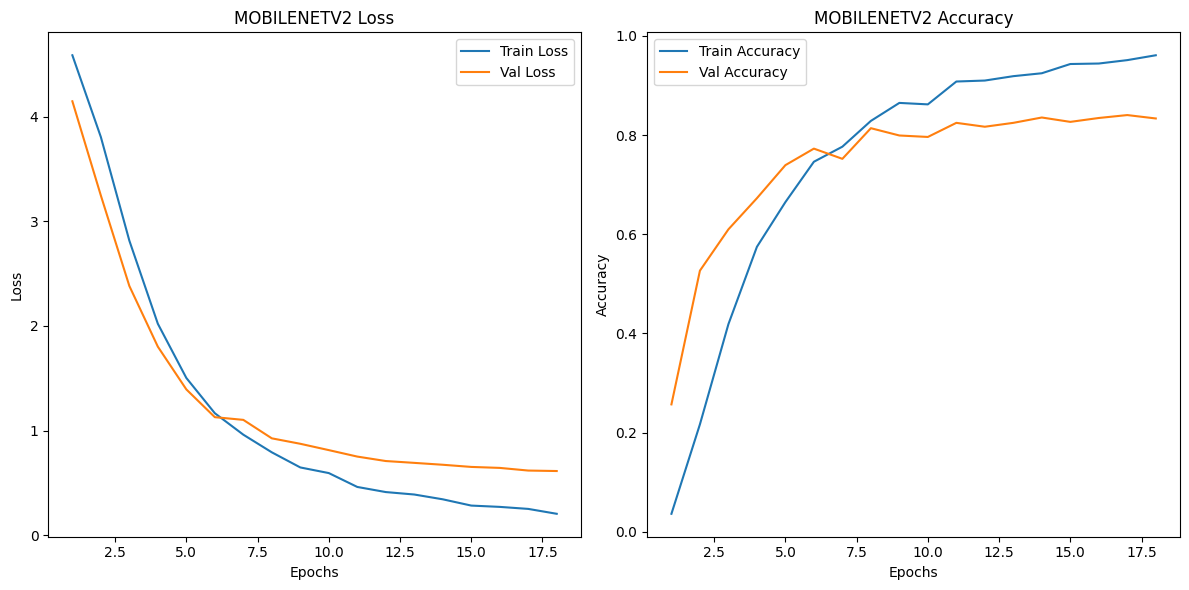

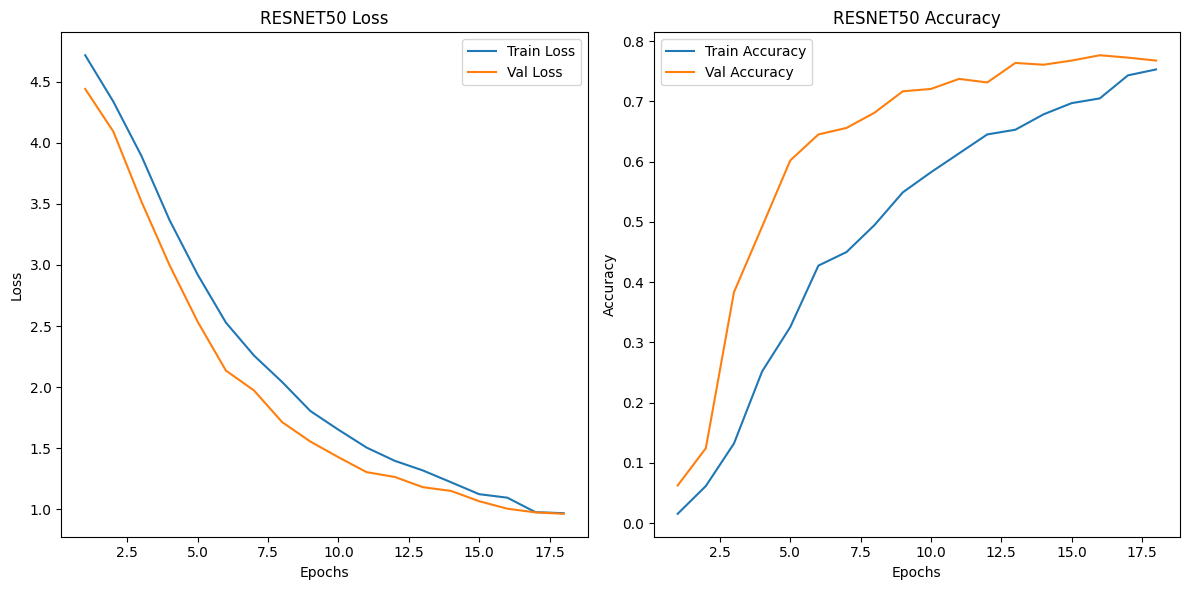

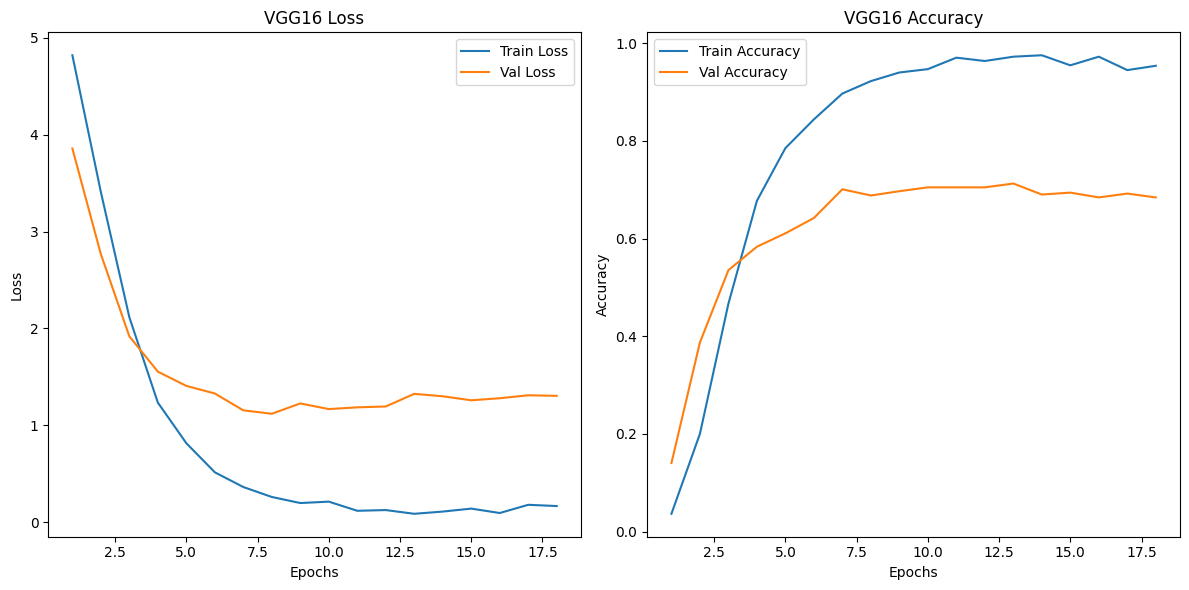

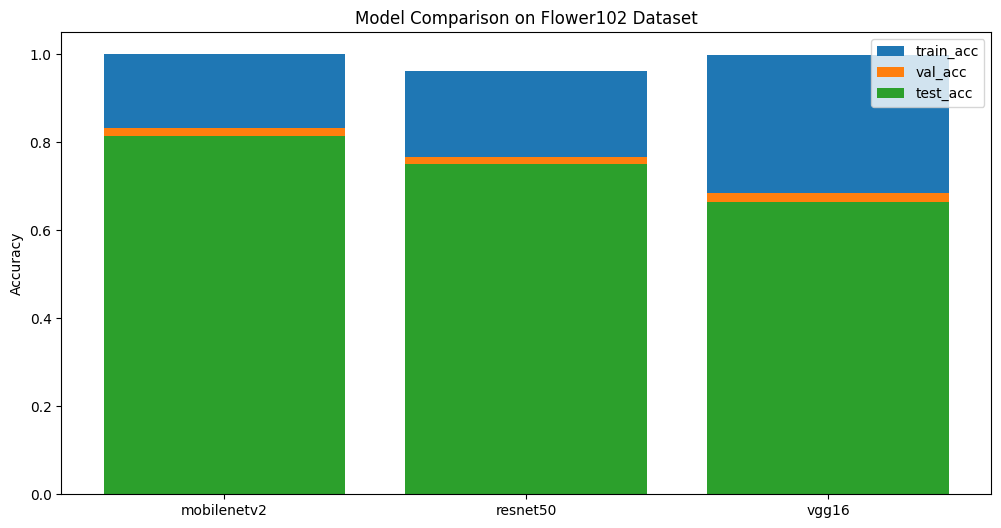

In [6]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def initialize_model(model_name, num_classes):
    if model_name == "mobilenetv2":
        model = models.mobilenet_v2(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(model.last_channel, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False
        model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes),
        )
    else:
        raise ValueError("Invalid model name")

    return model.to(device)

def get_criterion_and_optimizer(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    return criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader.dataset))
        val_acc.append(val_running_corrects / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

    return running_loss / len(loader.dataset), running_corrects / len(loader.dataset)

models_to_train = ["mobilenetv2", "resnet50", "vgg16"]
num_classes = 102
results = {}
train_val_epoch_data = {}

for model_name in models_to_train:
    print(f"Training {model_name}...")
    model = initialize_model(model_name, num_classes)
    criterion, optimizer = get_criterion_and_optimizer(model)
    train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=18)

    train_val_epoch_data[model_name] = {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
    }

    train_metrics = evaluate_model(model, train_loader, criterion)
    val_metrics = evaluate_model(model, val_loader, criterion)
    test_metrics = evaluate_model(model, test_loader, criterion)

    total_params = sum(p.numel() for p in model.parameters())
    learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    results[model_name] = {
        "train_loss": train_metrics[0],
        "train_acc": train_metrics[1],
        "val_loss": val_metrics[0],
        "val_acc": val_metrics[1],
        "test_loss": test_metrics[0],
        "test_acc": test_metrics[1],
        "total_params": total_params,
        "learnable_params": learnable_params,
    }

    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), f"saved_models/{model_name}_flower102.pth")

    print(f"\n{model_name.upper()} PARAMETERS:")
    print(f"Total Parameters: {total_params}")
    print(f"Learnable Parameters: {learnable_params}")

for model_name, metrics in results.items():
    print(f"\n{model_name.upper()} Results:")
    print(f"Train Loss: {metrics['train_loss']:.4f}, Train Accuracy: {metrics['train_acc']:.4f}")
    print(f"Validation Loss: {metrics['val_loss']:.4f}, Validation Accuracy: {metrics['val_acc']:.4f}")
    print(f"Test Loss: {metrics['test_loss']:.4f}, Test Accuracy: {metrics['test_acc']:.4f}")
    print(f"Total Parameters: {metrics['total_params']}")
    print(f"Learnable Parameters: {metrics['learnable_params']}")

for model_name, epoch_data in train_val_epoch_data.items():
    epochs = range(1, len(epoch_data["train_loss"]) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, epoch_data["train_loss"], label="Train Loss")
    plt.plot(epochs, epoch_data["val_loss"], label="Val Loss")
    plt.title(f"{model_name.upper()} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, epoch_data["train_acc"], label="Train Accuracy")
    plt.plot(epochs, epoch_data["val_acc"], label="Val Accuracy")
    plt.title(f"{model_name.upper()} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(12, 6))

for metric in ["train_acc", "val_acc", "test_acc"]:
    values = [results[model_name][metric] for model_name in models_to_train]
    plt.bar(models_to_train, values, label=metric)

plt.ylabel("Accuracy")
plt.title("Model Comparison on Flower102 Dataset")
plt.legend()
plt.show()

dar halat koli mobilenet behtar amal mikonad va sepas resnet50 va bad vgg16 ke in daqiqan bar khalaf parametr haye qabel yadgiri va parametr haye koli ast zira ke dar sakhtar mobilnet az idea haye behtar mesl Depthwise Separable Convolutions to reduce computation. va kolan hooshmandane tar ast va in kar neshan midahad ke faqat teedad parametr hara ziad kardan araye amoozesh tasir nadarad

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/18 - Train Loss: 4.6905, Train Acc: 0.0176, Val Loss: 4.6373, Val Acc: 0.0098
Epoch 2/18 - Train Loss: 4.4653, Train Acc: 0.0255, Val Loss: 4.9976, Val Acc: 0.0098
Epoch 3/18 - Train Loss: 4.3002, Train Acc: 0.0314, Val Loss: 4.1653, Val Acc: 0.0441
Epoch 4/18 - Train Loss: 4.1251, Train Acc: 0.0373, Val Loss: 4.8228, Val Acc: 0.0314
Epoch 5/18 - Train Loss: 4.0598, Train Acc: 0.0392, Val Loss: 3.9308, Val Acc: 0.0627
Epoch 6/18 - Train Loss: 3.9537, Train Acc: 0.0520, Val Loss: 3.7812, Val Acc: 0.0676
Epoch 7/18 - Train Loss: 3.8379, Train Acc: 0.0490, Val Loss: 4.2018, Val Acc: 0.0529
Epoch 8/18 - Train Loss: 3.7798, Train Acc: 0.0637, Val Loss: 4.0817, Val Acc: 0.0853
Epoch 9/18 - Train Loss: 3.7302, Train Acc: 0.0804, Val Loss: 3.9725, Val Acc: 0.1088
Epoch 10/18 - Train Loss: 3.6547, Train Acc: 0.0667, Val Loss: 3.6814, Val Acc: 0.0922
Epoch 11/18 - Train Loss: 3.5674, Train Acc: 0.0931, Val Loss: 3.4956, Val Acc: 0.0990
Epoch 12/18 - Train Loss: 3.4963, Train Acc: 0.0873,

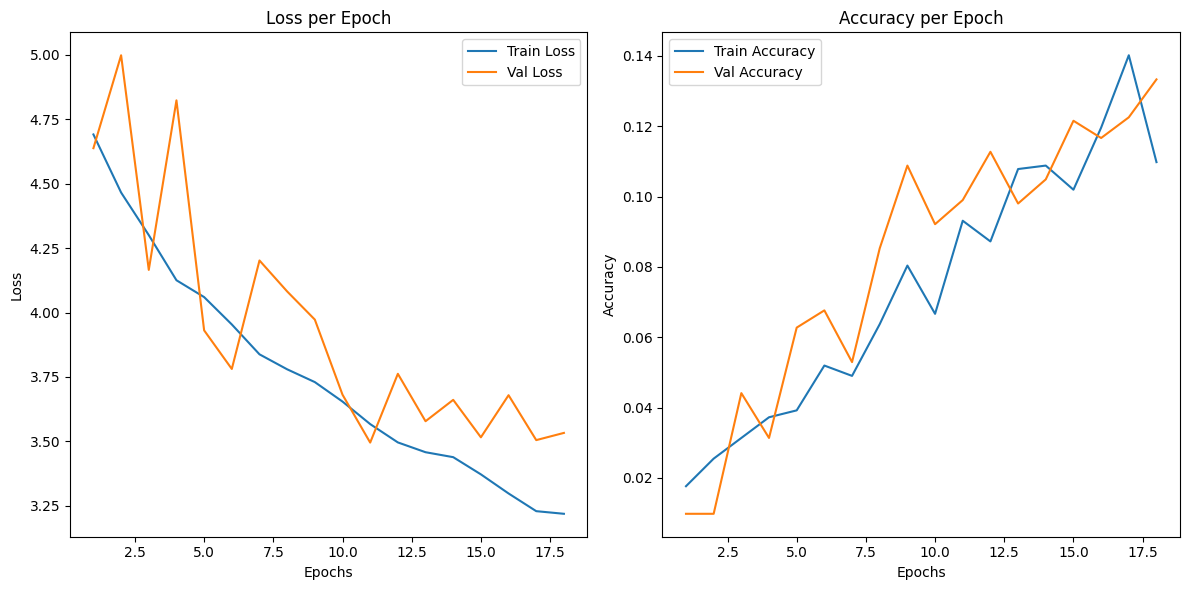

Test Loss: 3.6658, Test Accuracy: 0.1083


In [7]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

def initialize_mobilenetv2(num_classes):
    model = models.mobilenet_v2(pretrained=False)
    model.classifier = nn.Sequential(
        nn.Linear(model.last_channel, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, num_classes),
    )
    return model.to(device)

def get_criterion_and_optimizer(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return criterion, optimizer

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader.dataset))
        val_acc.append(val_running_corrects / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, "
              f"Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

    return running_loss / len(loader.dataset), running_corrects / len(loader.dataset)

num_classes = 102
model = initialize_mobilenetv2(num_classes)
criterion, optimizer = get_criterion_and_optimizer(model)

epochs = 18
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/mobilenetv2_random_weights_flower102.pth")


hamantoor ke qabel moshahede ast besyar accuracy paeen mishavad va 10% mishavad ba haman epoch zira ke az estekhraj feature estefade nakardim va in ahamiat transfer learning ra neshan midahad va neshan midahad ke on layeha cheqadr meqdareshan ahamiat dasht